In [1]:
%%time
import pandas as pd
import csv

act_test = pd.read_csv('./data/act_test.csv', parse_dates=['date'])
act_train = pd.read_csv('./data/act_train.csv', parse_dates=['date'])
ppl = pd.read_csv('./data/people.csv', parse_dates=['date'])

df_train = pd.merge(act_train, ppl, on='people_id', suffixes=('_act', '_ppl'))
act_test['dummy']=0
df_test = pd.merge(act_test, ppl, on='people_id', suffixes=('_act', '_ppl'))
labels = df_train['outcome']

CPU times: user 6.75 s, sys: 1.04 s, total: 7.79 s
Wall time: 7.99 s


In [2]:
# Describe datasets
def desc_dataset(dataset):
    desc_dataset_ = pd.DataFrame()
    colname = dataset.keys()
    
    dataset_type = []
    dataset_nunique = []
    
    for i in colname:
        dataset_type.append(dataset[i].dtypes)
        dataset_nunique.append(dataset[i].nunique())
        
    desc_dataset_['column_name'] = colname
    desc_dataset_['dtype'] = dataset_type
    desc_dataset_['n_unique'] = dataset_nunique
    
    return desc_dataset_

In [3]:
%%time
desc_act_train = desc_dataset(act_train)
desc_ppl = desc_dataset(ppl)
desc_df_train = desc_dataset(df_train)

CPU times: user 3.21 s, sys: 542 ms, total: 3.75 s
Wall time: 3.75 s


In [4]:
# Feature Engineering
def calender_convert(data):
    for table in [data]:
        table.insert(3, 'year_act', table['date_act'].dt.year)
        table.insert(4, 'month_act',table['date_act'].dt.month)
        table.insert(5, 'day_act', table['date_act'].dt.day)
        table.insert(6, 'weekday_act', table['date_act'].dt.weekday)
  
        table.insert(19, 'year_ppl', table['date_ppl'].dt.year)
        table.insert(20, 'month_ppl', table['date_ppl'].dt.month)
        table.insert(21, 'day_ppl', table['date_ppl'].dt.day)
        table.insert(22, 'weekday_ppl', table['date_ppl'].dt.weekday)
    
        table['from_join_to_act'] = (table['date_act'] - table['date_ppl']).astype('timedelta64[D]')
    
        del table['date_act']
        del table['date_ppl']
    return data

In [5]:
def preprocess_features(data, train_set=True, test_set=True):
    
    data = data.drop(['activity_id'], axis=1)
    data['people_id'] = data['people_id'].apply(lambda x: x.split('_')[1])
    data['people_id'] = pd.to_numeric(data['people_id']).astype(int)
    
    if(train_set):
        data = data.drop(['outcome'], axis=1)
        
    else:
        data = data.drop(['dummy'], axis=1)
    
    columns = list(data.columns)
    bools = columns[30:58]
    strings_act = columns[5:16]
    strings_ppl = columns[20:30]
    
    for col in bools:
        data[col] = pd.to_numeric(data[col]).astype(int)

    for col in strings_act:
        data[col] = data[col].fillna('type 0')
        data[col] = data[col].apply(lambda x: x.split(' ')[1])
        data[col] = pd.to_numeric(data[col].astype(int))
        
    for col in strings_ppl:
        data[col] = data[col].fillna('type 0')
        data[col] = data[col].apply(lambda x: x.split(' ')[1])
        data[col] = pd.to_numeric(data[col].astype(int))
        
    return data

In [6]:
%%time
  
df_train = calender_convert(df_train)
df_test = calender_convert(df_test)

feature_train = preprocess_features(df_train)
feature_test = preprocess_features(df_test, train_set=False)

CPU times: user 31.5 s, sys: 3.38 s, total: 34.9 s
Wall time: 34.9 s


In [7]:
# reference: https://www.kaggle.com/anokas/redhatxgb-bb505a62

from sklearn.cross_validation import LabelKFold
import numpy as np

train_mask, valid_mask = list(LabelKFold(feature_train['people_id'], n_folds=10))[0]

feature_test = feature_test.drop(['people_id'],axis=1)
feature_train = feature_train.drop(['people_id'], axis=1)

x_train = np.array(feature_train)[train_mask]
y_train = np.array(labels)[train_mask]

x_valid = np.array(feature_train)[valid_mask]
y_valid = np.array(labels)[valid_mask]

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
# parameter tuning on XGBoost
# reference : https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

import xgboost as xgb

params = {'max_depth':20,
          'learning_rate':0.1,
          'n_estimators':1000,
          'objective':'binary:logistic',
          'n_jobs':6,
          'eval_metric':'auc',
          'silent':False,
          'subsample':0.9,
          'colsample_bytree':0.9
          }

In [9]:
# Reference: http://xgboost.readthedocs.io/en/latest/python/python_api.html

clf=xgb.XGBClassifier(**params)

In [10]:
%%time
clf_fit=clf.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], eval_metric='auc', early_stopping_rounds=40)

[0]	validation_0-auc:0.993351	validation_1-auc:0.964933
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 40 rounds.
[1]	validation_0-auc:0.99672	validation_1-auc:0.967792
[2]	validation_0-auc:0.997698	validation_1-auc:0.969695
[3]	validation_0-auc:0.998331	validation_1-auc:0.971227
[4]	validation_0-auc:0.998782	validation_1-auc:0.972516
[5]	validation_0-auc:0.998955	validation_1-auc:0.973261
[6]	validation_0-auc:0.999041	validation_1-auc:0.974122
[7]	validation_0-auc:0.9991	validation_1-auc:0.974395
[8]	validation_0-auc:0.999262	validation_1-auc:0.974711
[9]	validation_0-auc:0.999354	validation_1-auc:0.975073
[10]	validation_0-auc:0.999419	validation_1-auc:0.975291
[11]	validation_0-auc:0.999502	validation_1-auc:0.975249
[12]	validation_0-auc:0.999539	validation_1-auc:0.975784
[13]	validation_0-auc:0.99958	validation_1-auc:0.976311
[14]	validation_0-auc:0.999624	validation_1-auc:0.976443
[1

[143]	validation_0-auc:1	validation_1-auc:0.981954
[144]	validation_0-auc:1	validation_1-auc:0.981965
[145]	validation_0-auc:1	validation_1-auc:0.981973
[146]	validation_0-auc:1	validation_1-auc:0.981968
[147]	validation_0-auc:1	validation_1-auc:0.981984
[148]	validation_0-auc:1	validation_1-auc:0.981997
[149]	validation_0-auc:1	validation_1-auc:0.981993
[150]	validation_0-auc:1	validation_1-auc:0.981999
[151]	validation_0-auc:1	validation_1-auc:0.982003
[152]	validation_0-auc:1	validation_1-auc:0.982001
[153]	validation_0-auc:1	validation_1-auc:0.981988
[154]	validation_0-auc:1	validation_1-auc:0.981974
[155]	validation_0-auc:1	validation_1-auc:0.981975
[156]	validation_0-auc:1	validation_1-auc:0.981995
[157]	validation_0-auc:1	validation_1-auc:0.981991
[158]	validation_0-auc:1	validation_1-auc:0.982004
[159]	validation_0-auc:1	validation_1-auc:0.982018
[160]	validation_0-auc:1	validation_1-auc:0.982019
[161]	validation_0-auc:1	validation_1-auc:0.982022
[162]	validation_0-auc:1	valida

In [ ]:
# make an outcome to submit
p_test = clf.predict(np.array(feature_test))

sub = pd.DataFrame()
sub['activity_id'] = df_test['activity_id']
sub['outcome'] = p_test
sub.to_csv('submit.csv', index=False)

In [11]:
def get_feature_importance(source_data, calculated_data):
    f_importance = pd.DataFrame()
    f_importance['feature'] = source_data.keys()
    f_importance['importance'] = calculated_data.feature_importances_
    
    f_importance = f_importance.sort_values(by=['importance'], ascending=False)
    
    return f_importance

In [12]:
f_importance = get_feature_importance(feature_train, clf_fit)

In [13]:
f_importance

,feature,importance
20,group_1,0.147079
58,from_join_to_act,0.134296
57,char_38,0.070943
17,day_ppl,0.069457
1,month_act,0.060675
2,day_act,0.055242
16,month_ppl,0.044747
26,char_7_ppl,0.042018
22,char_3_ppl,0.040407
18,weekday_ppl,0.033625


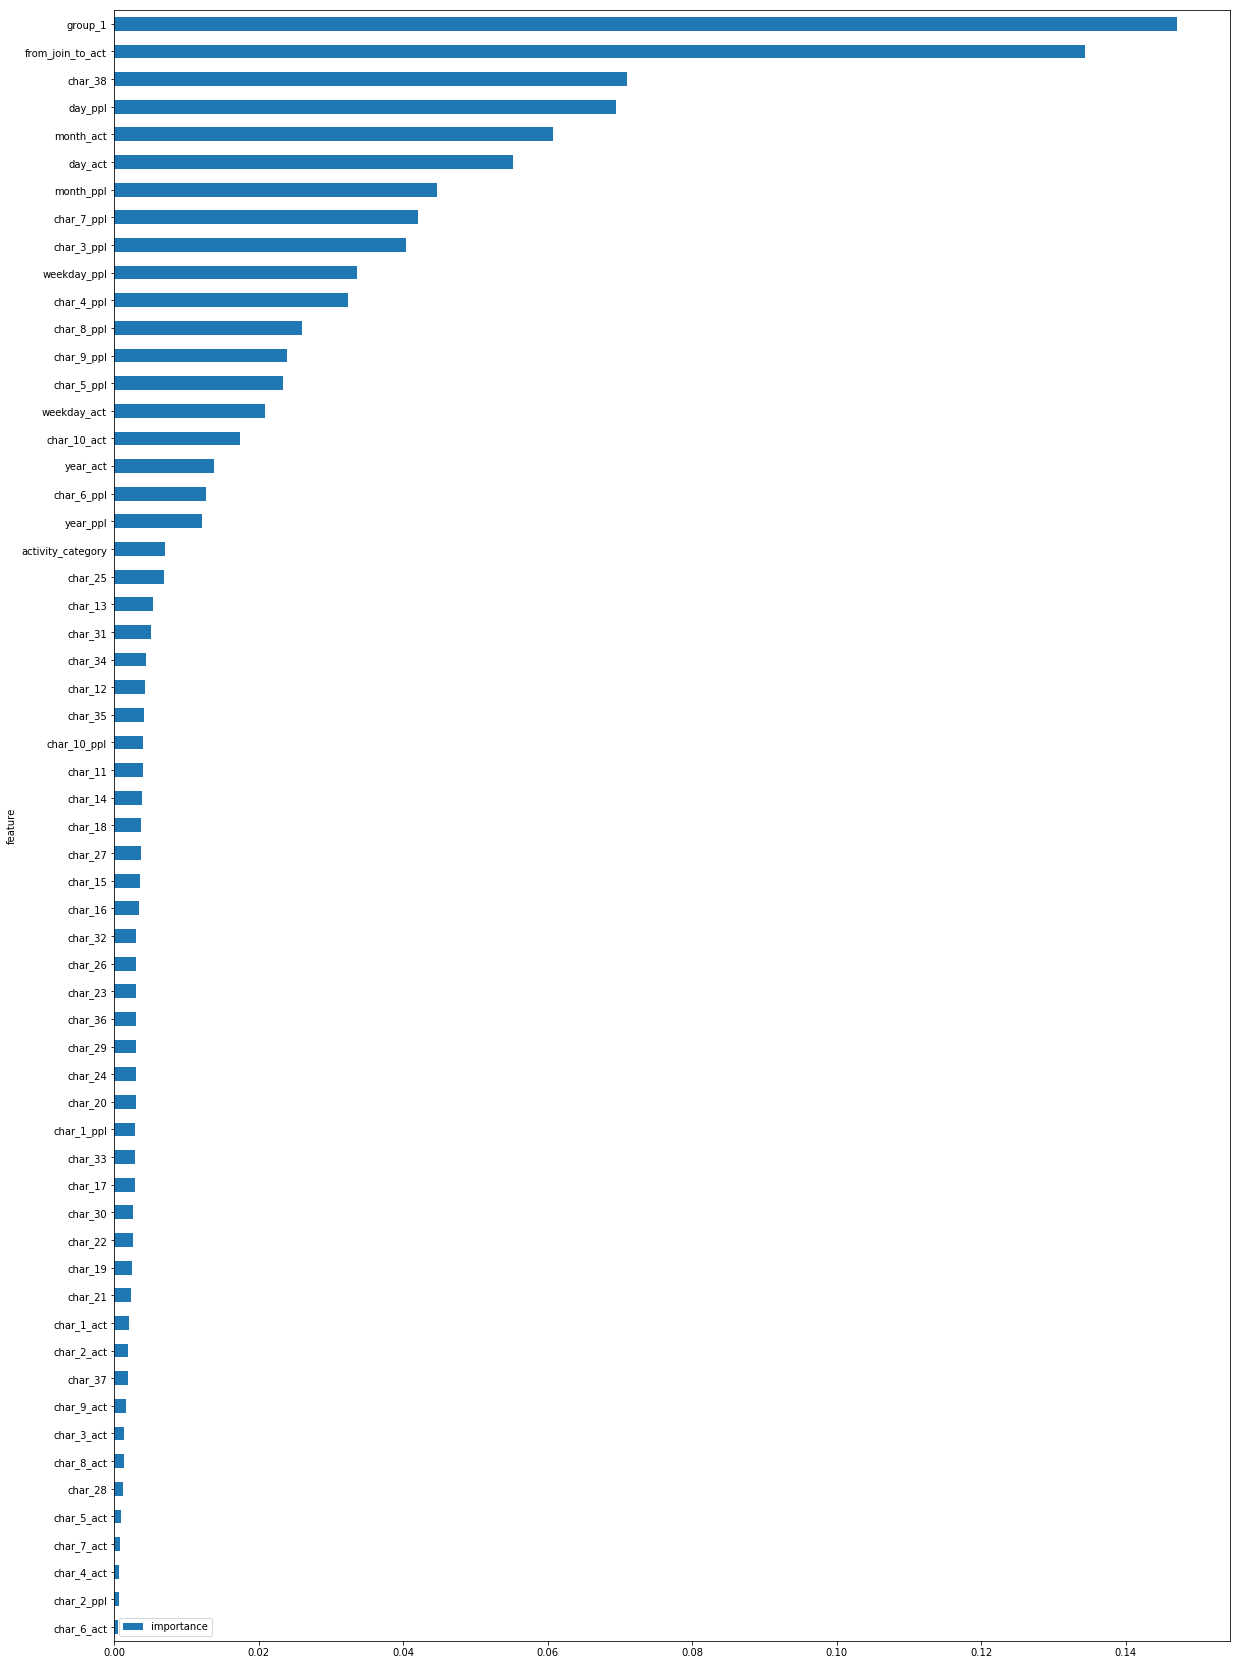

In [15]:
import matplotlib.pyplot as plt

# Reference: https://preinventedwheel.com/easy-matplotlib-bar-chart/
plt.rcParams['figure.figsize']=(20, 30)
f_importance = f_importance.sort_values(by=['importance']) # barh 에서는 정렬의 최하위에 있는 값이 가장 위에 배치된다. 따라서 가장 중요한 피쳐를 먼저 보고 싶다면 이처럼 ascending을 해줘야 한다.
f_importance.plot(f_importance['feature'], kind='barh')
plt.show()

In [18]:
def reduce_feature_by_importance(limit):
    feature_drop=[]
    for i in range(len(f_importance)):
        if f_importance['importance'][i] <= limit:
            feature_drop.append(f_importance['feature'][i])
    print('total features :', len(f_importance), '\nselected features :', len(f_importance)-len(feature_drop), '\nderelict features :', len(feature_drop))
    return feature_drop

In [19]:
feature_drop = reduce_feature_by_importance(0.001)

total features : 59 
selected features : 54 
derelict features : 5


In [22]:
def drop_features(origin_dataset, drop_list):
    
    for i in drop_list:
        data_ = origin_dataset.drop([i], axis=1)
        print('feature {} has dropped!'.format(i))
    return data_

In [23]:
feature_train_1 = drop_features(feature_train, feature_drop)
feature_test_1 = drop_features(feature_test, feature_drop)

feature char_4_act has dropped!
feature char_5_act has dropped!
feature char_6_act has dropped!
feature char_7_act has dropped!
feature char_2_ppl has dropped!
feature char_4_act has dropped!
feature char_5_act has dropped!
feature char_6_act has dropped!
feature char_7_act has dropped!
feature char_2_ppl has dropped!


In [24]:

x_train_1 = np.array(feature_train_1)[train_mask]

x_valid_1 = np.array(feature_train_1)[valid_mask]

In [25]:
clf_fit_1=clf.fit(x_train_1, y_train, eval_set=[(x_train_1, y_train), (x_valid_1, y_valid)], eval_metric='auc', early_stopping_rounds=40)

[0]	validation_0-auc:0.992514	validation_1-auc:0.961164
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 40 rounds.
[1]	validation_0-auc:0.996255	validation_1-auc:0.966485
[2]	validation_0-auc:0.997389	validation_1-auc:0.969334
[3]	validation_0-auc:0.997791	validation_1-auc:0.97005
[4]	validation_0-auc:0.998189	validation_1-auc:0.970969
[5]	validation_0-auc:0.998411	validation_1-auc:0.971859
[6]	validation_0-auc:0.998504	validation_1-auc:0.972601
[7]	validation_0-auc:0.998715	validation_1-auc:0.973378
[8]	validation_0-auc:0.998922	validation_1-auc:0.973802
[9]	validation_0-auc:0.999135	validation_1-auc:0.974281
[10]	validation_0-auc:0.999229	validation_1-auc:0.97453
[11]	validation_0-auc:0.999295	validation_1-auc:0.974807
[12]	validation_0-auc:0.999352	validation_1-auc:0.974818
[13]	validation_0-auc:0.999459	validation_1-auc:0.975606
[14]	validation_0-auc:0.999508	validation_1-auc:0.975951


[143]	validation_0-auc:1	validation_1-auc:0.981572
[144]	validation_0-auc:1	validation_1-auc:0.981586
[145]	validation_0-auc:1	validation_1-auc:0.981588
[146]	validation_0-auc:1	validation_1-auc:0.981599
[147]	validation_0-auc:1	validation_1-auc:0.981596
[148]	validation_0-auc:1	validation_1-auc:0.981598
[149]	validation_0-auc:1	validation_1-auc:0.981613
[150]	validation_0-auc:1	validation_1-auc:0.981619
[151]	validation_0-auc:1	validation_1-auc:0.981624
[152]	validation_0-auc:1	validation_1-auc:0.981622
[153]	validation_0-auc:1	validation_1-auc:0.981607
[154]	validation_0-auc:1	validation_1-auc:0.981592
[155]	validation_0-auc:1	validation_1-auc:0.981608
[156]	validation_0-auc:1	validation_1-auc:0.981607
[157]	validation_0-auc:1	validation_1-auc:0.981611
[158]	validation_0-auc:1	validation_1-auc:0.981612
[159]	validation_0-auc:1	validation_1-auc:0.981621
[160]	validation_0-auc:1	validation_1-auc:0.981619
[161]	validation_0-auc:1	validation_1-auc:0.981619
[162]	validation_0-auc:1	valida

In [27]:
# make an outcome to submit
p_test_1 = clf.predict(np.array(feature_test_1))

sub_1 = pd.DataFrame()
sub_1['activity_id'] = df_test['activity_id']
sub_1['outcome'] = p_test_1
sub_1.to_csv('submit_reduce.csv', index=False)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
